# Report ( 모비딕 )

## curaition 아이디어 소개

>저희 팀은 고객뿐만 아니라 증권회사에게도 이익이 될 수 있는 curation 방안을 생각했습니다.  
증권사는 고객들의 거래량이 늘어날 때 수수료를 통해서 금전적 이익을 얻습니다.  
일반적인 고객들에게 큰 수익을 내는 것보다 리스크를 잘 분배해서 손실을 얼마나 적게 보느냐가 더 중요합니다.  
양측의 이익을 위해서 저희는 '개인용 포트폴리오 curation'을 생각했습니다.
개인은 일반 펀드에서 많은 수수료를 지불해야 할 수 있는 포트폴리오 운영을 저희가 추천하는 curation으로 보다 쉽게 할 수 있습니다.  
포트폴리오 curation에는 그룹화된 고객의 성향에 맞게 원자재, 주식, 채권 같은 대략적인 금융상품군의 비율이 추천될 것입니다.
추천된 비율 안에서 고객이 직접 선택해서 세부적인 상품들을 채워넣을 수 있게 프레임을 제공합니다.
이를 통해 고객들은 포트폴리오를 통한 분할투자의 효과를 얻을 수 있게됩니다.  
포트폴리오의 각 요소들은 시간이 지남에 따라 그 비율이 변하고, 본래 의도했던 리스크에서 벗어날 수 있습니다.  
그때 필수적으로 포트폴리오에서는 리밸런싱이라는 작업을 해야합니다.  
금융사는 자사 포트폴리오 curaition 서비스를 이용한 고객들에게 그 비율의 표준편차가 일정정도 이상 벗어나면 리밸런싱을 자동적으로 진행해주거나 고객에게 알림을 보내서 리밸런싱을 유도할 수 있습니다.  
리밸런싱으로 하면서 발생하는 거래들의 수수료를 통해서 금융사는 그만큼의 금전적이득을 얻을 수 있습니다.  
저희 '개인용 포트폴리오 curation'은 고객과 증권사 양측이 모두 이익을 얻을 수 있는 win-win 전략입니다.  

## 표적 Data

> 포트폴리오는 단기 투자보다는 장기 투자에 최적화된 전략입니다.  
거래량이 많고 뚜렷한 철학이 있는 단기 투자자들에게 저희가 제공하는 curaition은 효용이 떨어질 것 입니다.  
장기적 투자를 하는 고객들이 포트폴리오 curaition을 했을 때 양측에게 모두 이익이 될 것이라고 판단했습니다.  
거래량과 접속량이 적은 고객들의 Data를 표적 Data로 설정하는 것을 일차적인 목표로 설정했습니다.

## 사용할 패키지 불러오기

- 설치

In [229]:
# 베이스라인 코드
# pip install pandasql
# pip install yellowbrick
# !sudo apt-get install -y fonts-nanum
# !sudo fc-cache -fv
# !rm ~/.cache/matplotlib -rf

- import

In [230]:
import matplotlib
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import numpy as np
import pandas as pd
from tqdm import tqdm
from pandasql import sqldf
from sklearn.cluster import KMeans
from sklearn.preprocessing import RobustScaler
from sklearn.preprocessing import StandardScaler
import random

matplotlib.rcParams['font.family']='Malgun Gothic'
matplotlib.rcParams['font.size']=15 # 글자크기
matplotlib.rcParams['axes.unicode_minus']=False # -깨짐현상 해결

## 주 데이터 정의(클래스)

In [231]:
class Data:
    def __init__(self, mts, tot, byn_sll):
        self.mts = mts # mts_mm_access_type(MTS월단위접속패턴)
        self.tot = tot # tot_ivs_te_sgm_cd(총투자기간세그먼트코드)
        self.byn_sll = byn_sll # itg_byn_cns_qty + itg_sll_cns_qty(통합 매매 체결 수량)


    def __str__(self):
        return 'mts : {}, tot : {}, byn_sll : {}'.format(self.mts, self.tot, self.byn_sll)

## 데이터 다운로드

In [232]:
# 베이스라인 코드
# !gdown --id 1Qwz-dFgLNcC9zEXY3mqHoLVr73qOgTTv
# zf = zipfile.ZipFile("경진대회 예선 데이터.zip")
# zf.setpassword(b"nh1212!")
# zf.extractall()

## 데이터 추출

- 이상치 제거 및 데이터 join

> 먼저 가장 최근의 데이터를 가지고 판단하기 위해 cus_ifo.csv파일에서 bae_ym(고객정보기준년월)이 202206(22년 6월)인 데이터만 가져왔습니다.  
그다음 bas_stk_trd_tp_cd(기본주식거래유형코드)에서 1과 2를 가지는 Scalper와 Day trader를 target에 맞지 않는 고객군으로 보고 제외하였습니다.  
또한 tot_ivs_te_sgm_cd(총투자기간세그먼트코드)에서 99를 이상치로 보고 통합 매매 체결 수량에서 10000이상을 Scalper의 데이터로 판단하여 제거하였습니다.  
그뒤에 act_no(계좌번호(가명화))를 기준으로 각각 cus_ifo.csv파일과 cus_itg_sct_bnc.csv파일에 있던 데이터를 intersection join하였습니다.
> - mts_mm_access_typeMTS(월단위접속패턴) -> 각 자리수의 합(110010 -> 3)  
> - itg_byn_cns_qty(통합매수체결수량) + itg_sll_cns_qty(통합매도체결수량) -> 통합 매매 체결 수량

In [233]:
cus_ifo = pd.read_csv("./cus_ifo.csv", header=0, usecols=['act_no', 'mts_mm_access_type', 'tot_ivs_te_sgm_cd', 'bas_stk_trd_tp_cd', 'bse_ym'])
cus_ifo=cus_ifo.loc[cus_ifo['bse_ym']==202206] # 22년 6월 info 정보만 받기

cus_itg = pd.read_csv('./cus_itg_sct_bnc.csv', header=0, usecols=['act_no', 'itg_byn_cns_qty', 'itg_sll_cns_qty'])

cus_ifo['mts_mm_access_type'] = cus_ifo['mts_mm_access_type'].astype('string')
cus_ifo['act_no'] = cus_ifo['act_no'].astype('string')
cus_itg['act_no'] = cus_itg['act_no'].astype('string')

data_mts = {}
data_tot = {}
for row_i, row in cus_ifo.iterrows():
    if row_i > 0 and str(row['bas_stk_trd_tp_cd']) != '1' and str(row['bas_stk_trd_tp_cd']) != '2' and str(row['tot_ivs_te_sgm_cd']) != '99':
        data_mts[row['act_no']] = row['mts_mm_access_type'].count('1')
        data_tot[row['act_no']] = row['tot_ivs_te_sgm_cd']

data_byn_sll = {}
for row_i, row in cus_itg.iterrows():
    if row_i > 0:
        byn = row['itg_byn_cns_qty']
        sll = row['itg_sll_cns_qty']
        if row['act_no'] in data_byn_sll:
            tmp = data_byn_sll[row['act_no']]
            data_byn_sll[row['act_no']] = tmp+byn+sll
        else:
            data_byn_sll[row['act_no']] = byn+sll
        

data_set = {}
for key in data_byn_sll:
    if key in data_mts and data_byn_sll[key] <= 10000:
        data_set[key] = Data(data_mts[key], data_tot[key], data_byn_sll[key])

- DataFrame으로 변환

In [234]:
mts_list = []
tot_list = []
byn_sll_list = []
for key in data_set.keys():
    mts_list.append(data_set[key].mts)
    tot_list.append(data_set[key].tot)
    byn_sll_list.append(data_set[key].byn_sll)

df = pd.DataFrame({'act_no':data_set.keys(), 'mts_mm_access_type':mts_list, 'tot_ivs_te_sgm_cd':tot_list, 'byn_sll':byn_sll_list})

## 데이터 시각화

### 6개월 간 접속 개월 수

- 데이터

In [235]:
df_mts=df['mts_mm_access_type'].value_counts()
df_mts

6    5409
5     977
3     813
4     809
2     765
1     723
Name: mts_mm_access_type, dtype: int64

- 시각화

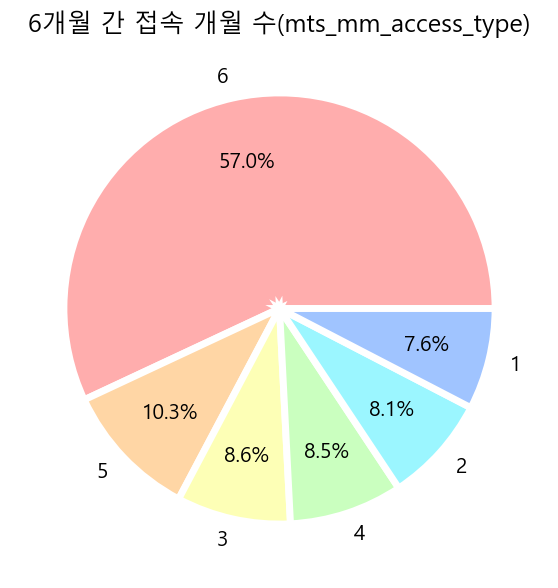

In [236]:
colors=['#ffadad', '#ffd6a5', '#fdffb6', '#caffbf', '#9bf6ff', '#a0c4ff']
wedgeprops={'edgecolor':'w', 'linewidth':5}

plt.figure(figsize=(7,7))
plt.pie(df_mts,labels=df_mts.index,autopct='%.1f%%',colors=colors,pctdistance=0.7,wedgeprops=wedgeprops)
plt.title('6개월 간 접속 개월 수(mts_mm_access_type)')
plt.show()

### 총 투자기간

- 데이터

In [237]:
df_tot=df['tot_ivs_te_sgm_cd'].value_counts()
df_tot

3    4361
1    2678
2    1059
4     559
6     420
5     419
Name: tot_ivs_te_sgm_cd, dtype: int64

- 시각화

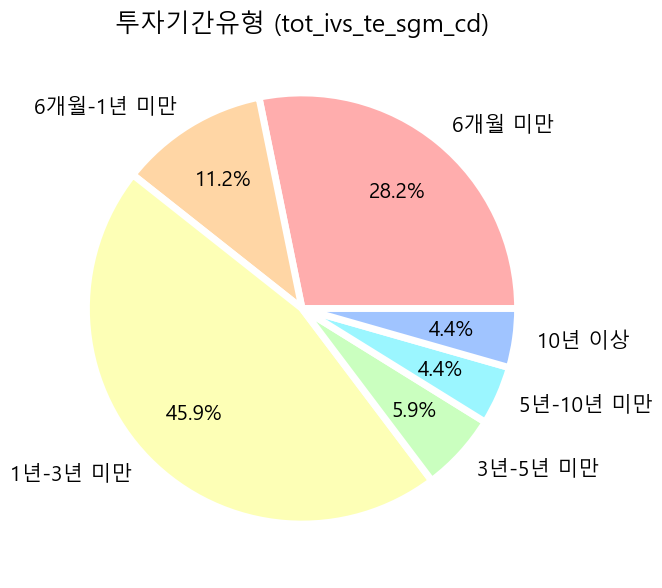

In [238]:
colors=['#ffadad', '#ffd6a5', '#fdffb6', '#caffbf', '#9bf6ff', '#a0c4ff']
labels=['6개월 미만','6개월-1년 미만', '1년-3년 미만', '3년-5년 미만', '5년-10년 미만', '10년 이상']
wedgeprops={'edgecolor':'w', 'linewidth':5}

df_tot.sort_index(inplace = True)
plt.figure(figsize=(7,7))
plt.pie(df_tot,labels=labels,autopct='%.1f%%',colors=colors,pctdistance=0.7,wedgeprops=wedgeprops)
plt.title('투자기간유형 (tot_ivs_te_sgm_cd)')
plt.show()

### 거래량

- 데이터

In [239]:
df1=df['byn_sll'].value_counts()
df1

0.0       4345
1.0        431
2.0        287
3.0        172
4.0        112
          ... 
2927.0       1
8400.0       1
654.0        1
9426.0       1
663.0        1
Name: byn_sll, Length: 1545, dtype: int64

- 시각화

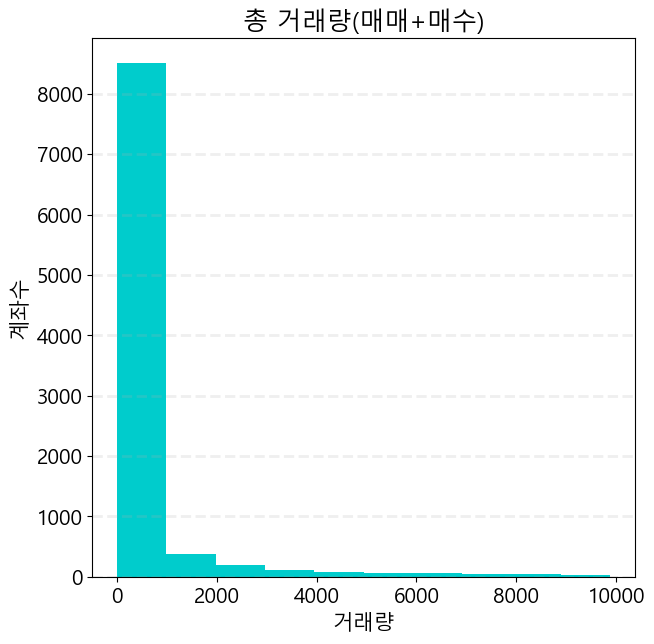

In [240]:
plt.figure(figsize=(7,7))
plt.title('총 거래량(매매+매수)')
df['byn_sll'].hist(color='#00CCCC')
plt.xlabel('거래량')
plt.ylabel('계좌수')
plt.grid(axis='y',alpha=0.2,linestyle='--',linewidth=2)
plt.grid(axis='x',alpha=0)
plt.show()

## 전체 데이터 분포

- scaling 전

In [241]:
X_or=df.to_numpy()
X=X_or[:,1:]
X

array([[1, 1, 0.0],
       [6, 3, 0.0],
       [6, 3, 0.0],
       ...,
       [6, 3, 0.0],
       [6, 3, 7.0],
       [3, 1, 2.0]], dtype=object)

- RobustScale
>Outlier를 최소화 하기 위해 중간값과 사분위값을 사용하는 RobustScaler를 사용하였습니다.

In [242]:
sc = RobustScaler()
X = sc.fit_transform(X)
X

array([[-2.5       , -1.        , -0.01075269],
       [ 0.        ,  0.        , -0.01075269],
       [ 0.        ,  0.        , -0.01075269],
       ...,
       [ 0.        ,  0.        , -0.01075269],
       [ 0.        ,  0.        ,  0.06451613],
       [-1.5       , -1.        ,  0.01075269]])

- 시각화

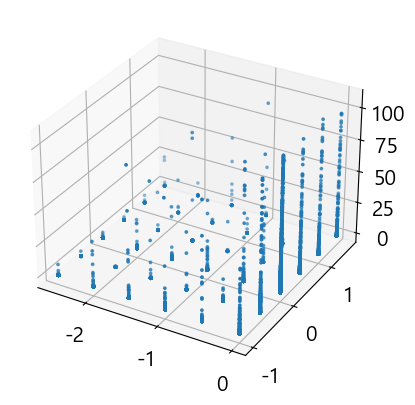

In [243]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(X[:,0], X[:,1], X[:,2], s=3)
plt.show()

## 머신러닝을 활용한 데이터 분석

### 분석전 합당성 확인

- Elbow Method
>데이터의 군집화 가능성을 확인하기 위해 Elbow Method를 이용하였습니다.  
2개 내지 3개의 Cluster로 나누는것이 합당하다는것을 확인하여 목표했던 2개의 Cluster로 분류를 진행하였습니다.

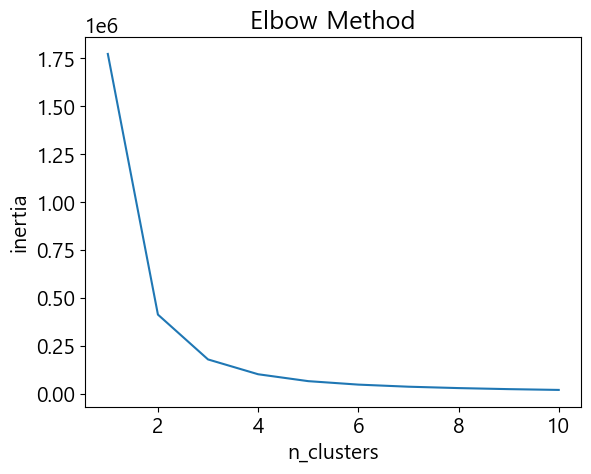

In [244]:
inertia_list = []
for i in range(1, 11):
    kmeans = KMeans(n_clusters=i, init='k-means++', random_state=0)
    kmeans.fit(X)
    inertia_list.append(kmeans.inertia_) # 각 지점으로부터 클러스터의 중심(centroid) 까지의 거리의 제곱의 합
    
plt.plot(range(1, 11), inertia_list)
plt.title('Elbow Method')
plt.xlabel('n_clusters')
plt.ylabel('inertia')
plt.show()

- Cluster 갯수

In [245]:
K=2

### 분류 진행

- kMeans
>별도의 label이 없이 주어진 데이터에서 군집화 시키기위해 kMeans++ 알고리즘을 적용하였습니다.

In [246]:
kmeans = KMeans(n_clusters=K, random_state=0) # default init 값이 k-means++ 라서 안적어도 상관없음.
# kmeans.fit(X)
y_kmeans = kmeans.fit_predict(X)
y_kmeans

array([0, 0, 0, ..., 0, 0, 0])

- Cluster 중심 확인

In [247]:
centers = kmeans.cluster_centers_ # 클러스터의 중심점 (centroid) 좌표
centers

array([[-0.64314962, -0.21917884,  1.7133107 ],
       [-0.09347826,  0.22065217, 57.4350321 ]])

- Cluster 시각화
>군집화를 진행한 결과 데이터로 준 각각의 요소가 모두 큰 집단과 작은 집단으로 나뉘는 것을 확인할 수 있었습니다.  
즉, 접속횟수, 투자기간 그리고 거래량은 비례관계에 있다는것을 확인했습니다.

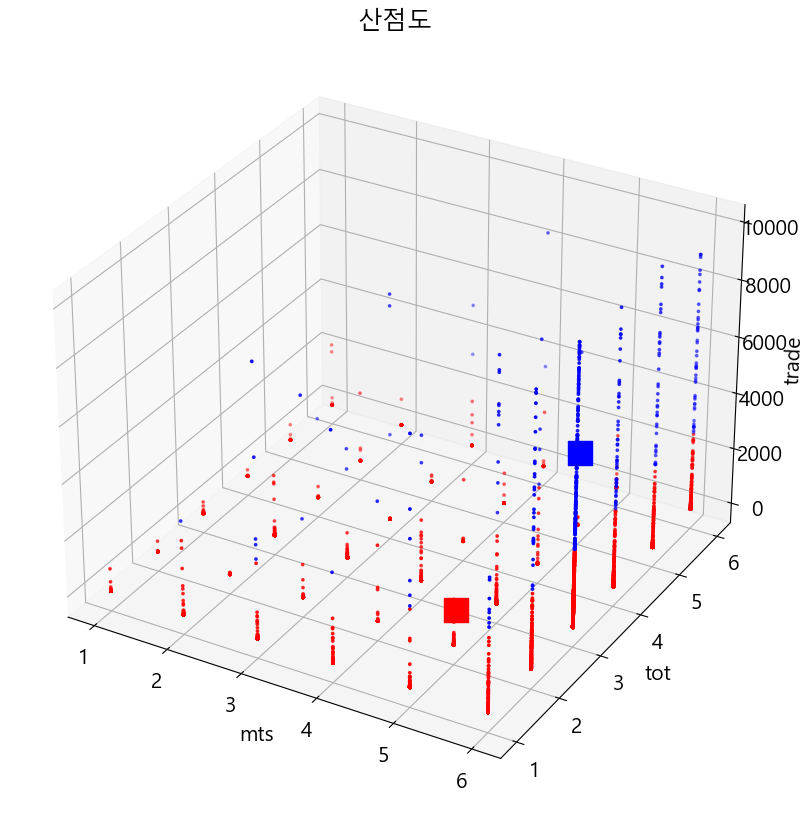

In [248]:
X_org = sc.inverse_transform(X)

centers_org = sc.inverse_transform(centers)
centers_org

fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111, projection='3d')

color=['r','b']

for cluster in range(K):
    ax.scatter(X_org[y_kmeans == cluster, 0], X_org[y_kmeans == cluster, 1], X_org[y_kmeans == cluster, 2], s=3,color=color[cluster]) # 각 데이터
    ax.scatter(centers_org[cluster, 0], centers_org[cluster, 1],centers_org[cluster, 2] ,s=300, color=color[cluster], marker='s') # 중심점 네모



plt.title('산점도')
ax.set_xlabel('mts')
ax.set_ylabel('tot')
ax.set_zlabel('trade')
plt.show()

### 군집 재분석
>추후 포트폴리오 curation을 위한 각 집단의 특성을 가리기 위해 재분석을 진행하였습니다.

- 집단 크기 확인

In [249]:
X_red=X_or[y_kmeans==0]
X_blue=X_or[y_kmeans==1]

print('red  : ', X_red.shape)
print('blue : ', X_blue.shape)

df['cluster'] = y_kmeans
print(df)

red  :  (9036, 4)
blue :  (460, 4)
                                                 act_no  mts_mm_access_type  \
0     4c272f9facccc618a111c42576be006390ea9775407c02...                   1   
1     628426b03d25a2ae774539e19d783777cb56a4910e547e...                   6   
2     555452034340e408093f1c25b468b78935ca78eca4225a...                   6   
3     57a9de76d17175c56bb4a872ee0a6269be21f38fb0937f...                   6   
4     1b0c986dbe5004d731b1cc24b8586d1d9035cfcd459e12...                   6   
...                                                 ...                 ...   
9491  68c3870368bbc5e067d184ca0e8fa757717c4ae64f3e97...                   4   
9492  41cff1fb07509a7e36d5b0578abf40301d167698f3bcfb...                   2   
9493  484fde543de8e7383ee3070a4b36baea247366ba6aca13...                   6   
9494  14b6c2ef1b9f411b39bb88cc58bc11519545a2843a2046...                   6   
9495  8a302c32df0a3110af9fea8285cb720cfba9cd57b87123...                   3   

      tot_ivs_te

- 포트폴리오 추천을 하지 않는 집단
>전체 표본에서 봤을때 투자기간이 긴 편에 속하며 매매량의 분포도 편차가 있고 거의 매달 MTS에 접속하는것으로 보아 본인의 투자경향이 뚜렷한 집단으로 판단된다.  
따라서 별도의 포트폴리오 추천은 적절하지 않고 추후 별도의 종목추천이 적절하다.

C:\Users\Min\AppData\Local\Temp\ipykernel_26672\1560295349.py:23: UserWarning: FixedFormatter should only be used together with FixedLocator
  axs[0, 1].set_xticklabels(labels,rotation=60)


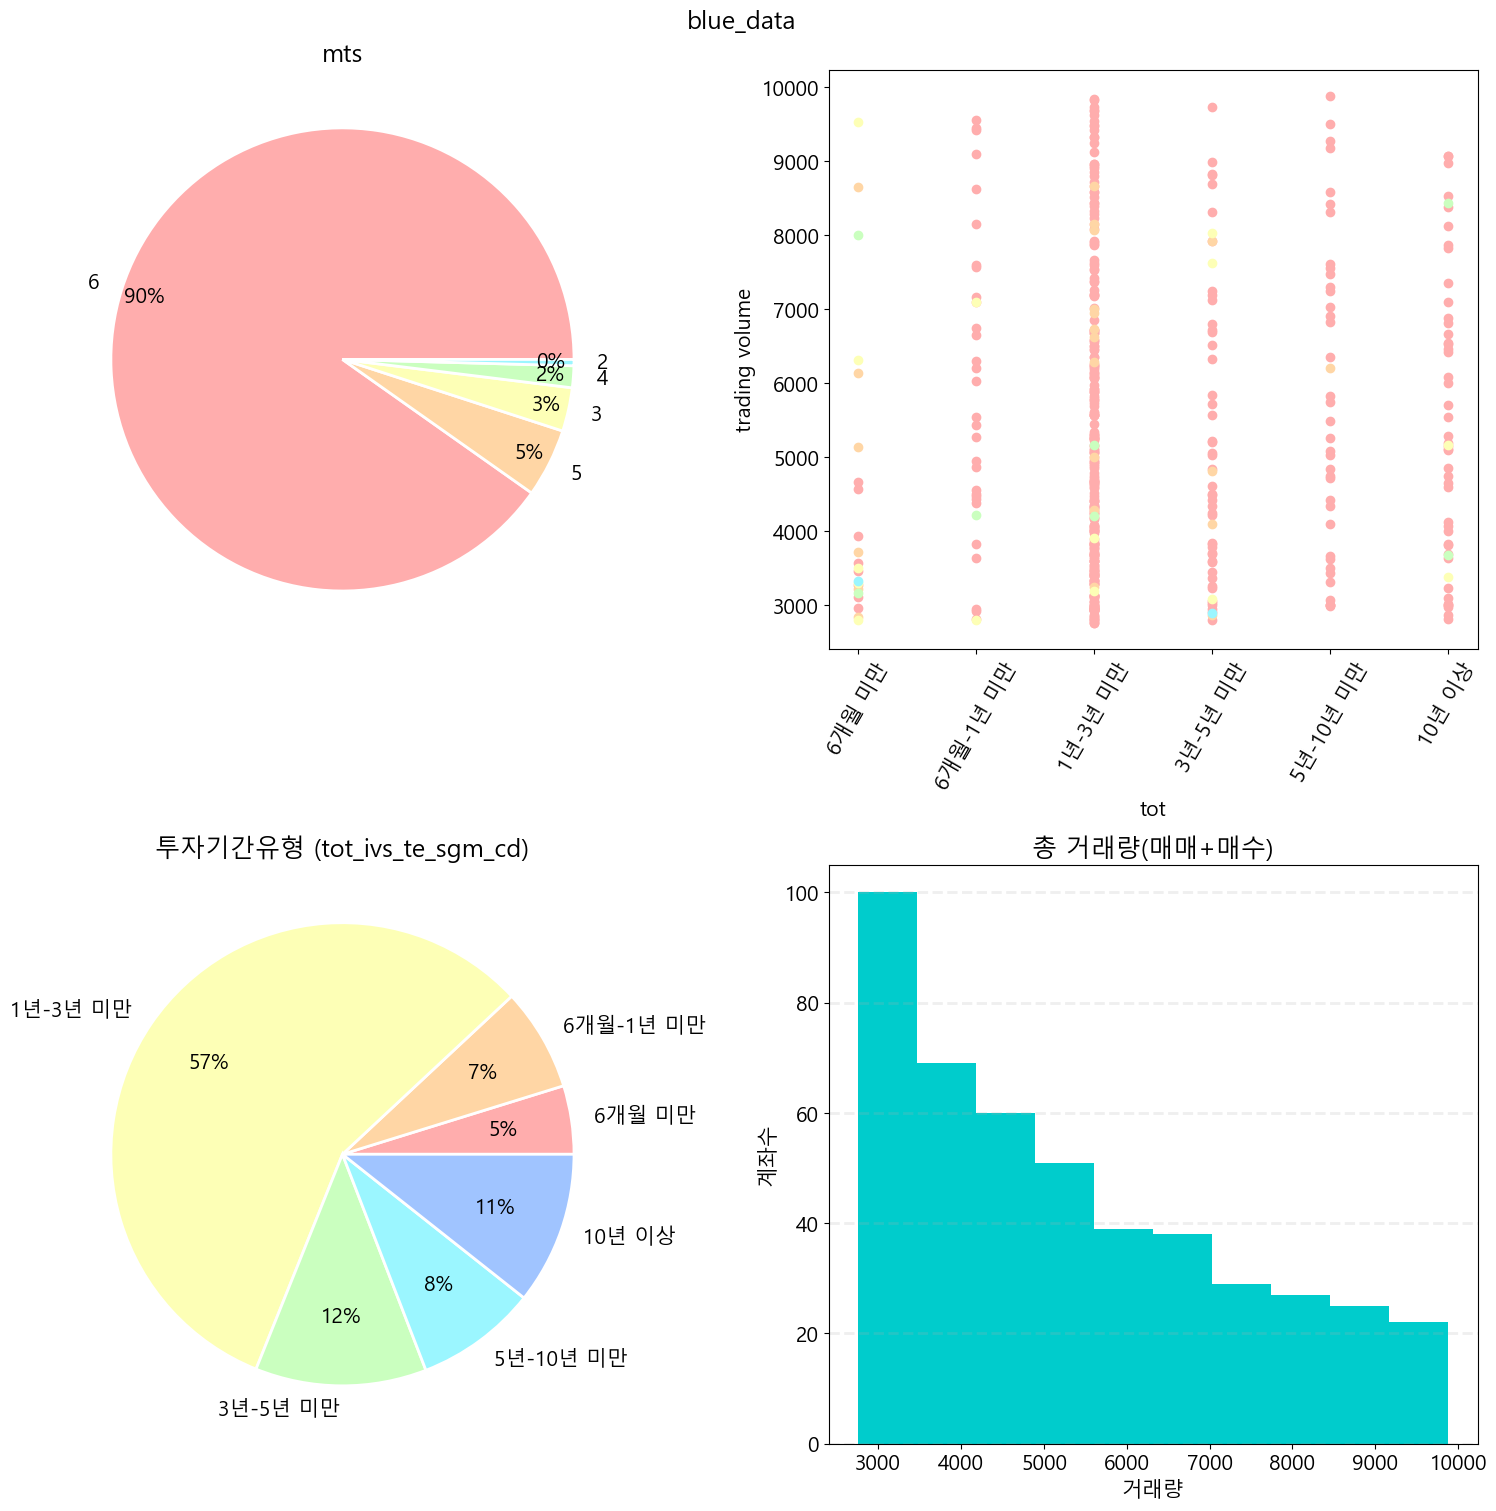

In [250]:
df_blue=pd.DataFrame(X_blue)

fig, axs=plt.subplots(2,2,figsize=(15,15), constrained_layout=True)
fig.suptitle('blue_data')

#첫 번째 그래프
colors=['#ffadad', '#ffd6a5', '#fdffb6', '#caffbf', '#9bf6ff', '#a0c4ff']
wedgeprops={'edgecolor':'w', 'linewidth':2}
df_blue_mts=df_blue[1].value_counts()

axs[0, 0].pie(df_blue_mts, labels=df_blue_mts.index, autopct='%.0f%%', colors=colors, pctdistance=0.9, wedgeprops=wedgeprops)
axs[0, 0].set_title('mts')

#두 번째 그래프
k=0
for idx in df_blue_mts.index:
    axs[0, 1].scatter(df_blue.loc[df_blue[1]==idx][2], df_blue.loc[df_blue[1]==idx][3], color=colors[k])
    axs[0, 1].set_xlabel('tot')
    axs[0, 1].set_ylabel('trading volume')
    k+=1
    
labels=['','6개월 미만','6개월-1년 미만', '1년-3년 미만', '3년-5년 미만', '5년-10년 미만', '10년 이상']    
axs[0, 1].set_xticklabels(labels,rotation=60)

#세 번째 그래프
labels=['6개월 미만','6개월-1년 미만', '1년-3년 미만', '3년-5년 미만', '5년-10년 미만', '10년 이상']
df_blue_tot=df_blue[2].value_counts()
df_blue_tot.sort_index(inplace = True)

axs[1, 0].pie(df_blue_tot, labels=labels, autopct='%.0f%%', colors=colors, pctdistance=0.7, wedgeprops=wedgeprops)
axs[1, 0].set_title('투자기간유형 (tot_ivs_te_sgm_cd)')

#네 번째 그래프
axs[1, 1].set_title('총 거래량(매매+매수)')
axs[1, 1].hist(df_blue[3], color='#00CCCC')
axs[1, 1].set_xlabel('거래량')
axs[1, 1].set_ylabel('계좌수')
axs[1, 1].grid(axis='y',alpha=0.2,linestyle='--',linewidth=2)
axs[1, 1].grid(axis='x',alpha=0)

plt.show()

- 포트폴리오가 필요한 집단
>집단의 크기 차이에서 알 수 있듯이 평범한 투자자로 분류할 수 있을 집단이다.  
집단 내에서 매매량의 편차가 크지 않고 위의 집단에 비해 거래량이 적으며 전체 표본의 비율이 투자기간유형중 1년에서 3년이 가장 많아 높게 나오지만 위의 집단과 비교해보면 확연히 투자기간이 길지 않음을 확인할 수 있다. 또한 MTS를 접속하지 않는 달이 위의 집단보다 더 많다.  
따라서 투자경력이 부족하며 투자와 매매에 소극적인 집단으로 볼 수 있고 포트폴리오 추천이 적절한 집단이다.

C:\Users\Min\AppData\Local\Temp\ipykernel_26672\3804209704.py:24: UserWarning: FixedFormatter should only be used together with FixedLocator
  axs[0, 1].set_xticklabels(labels,rotation=60)


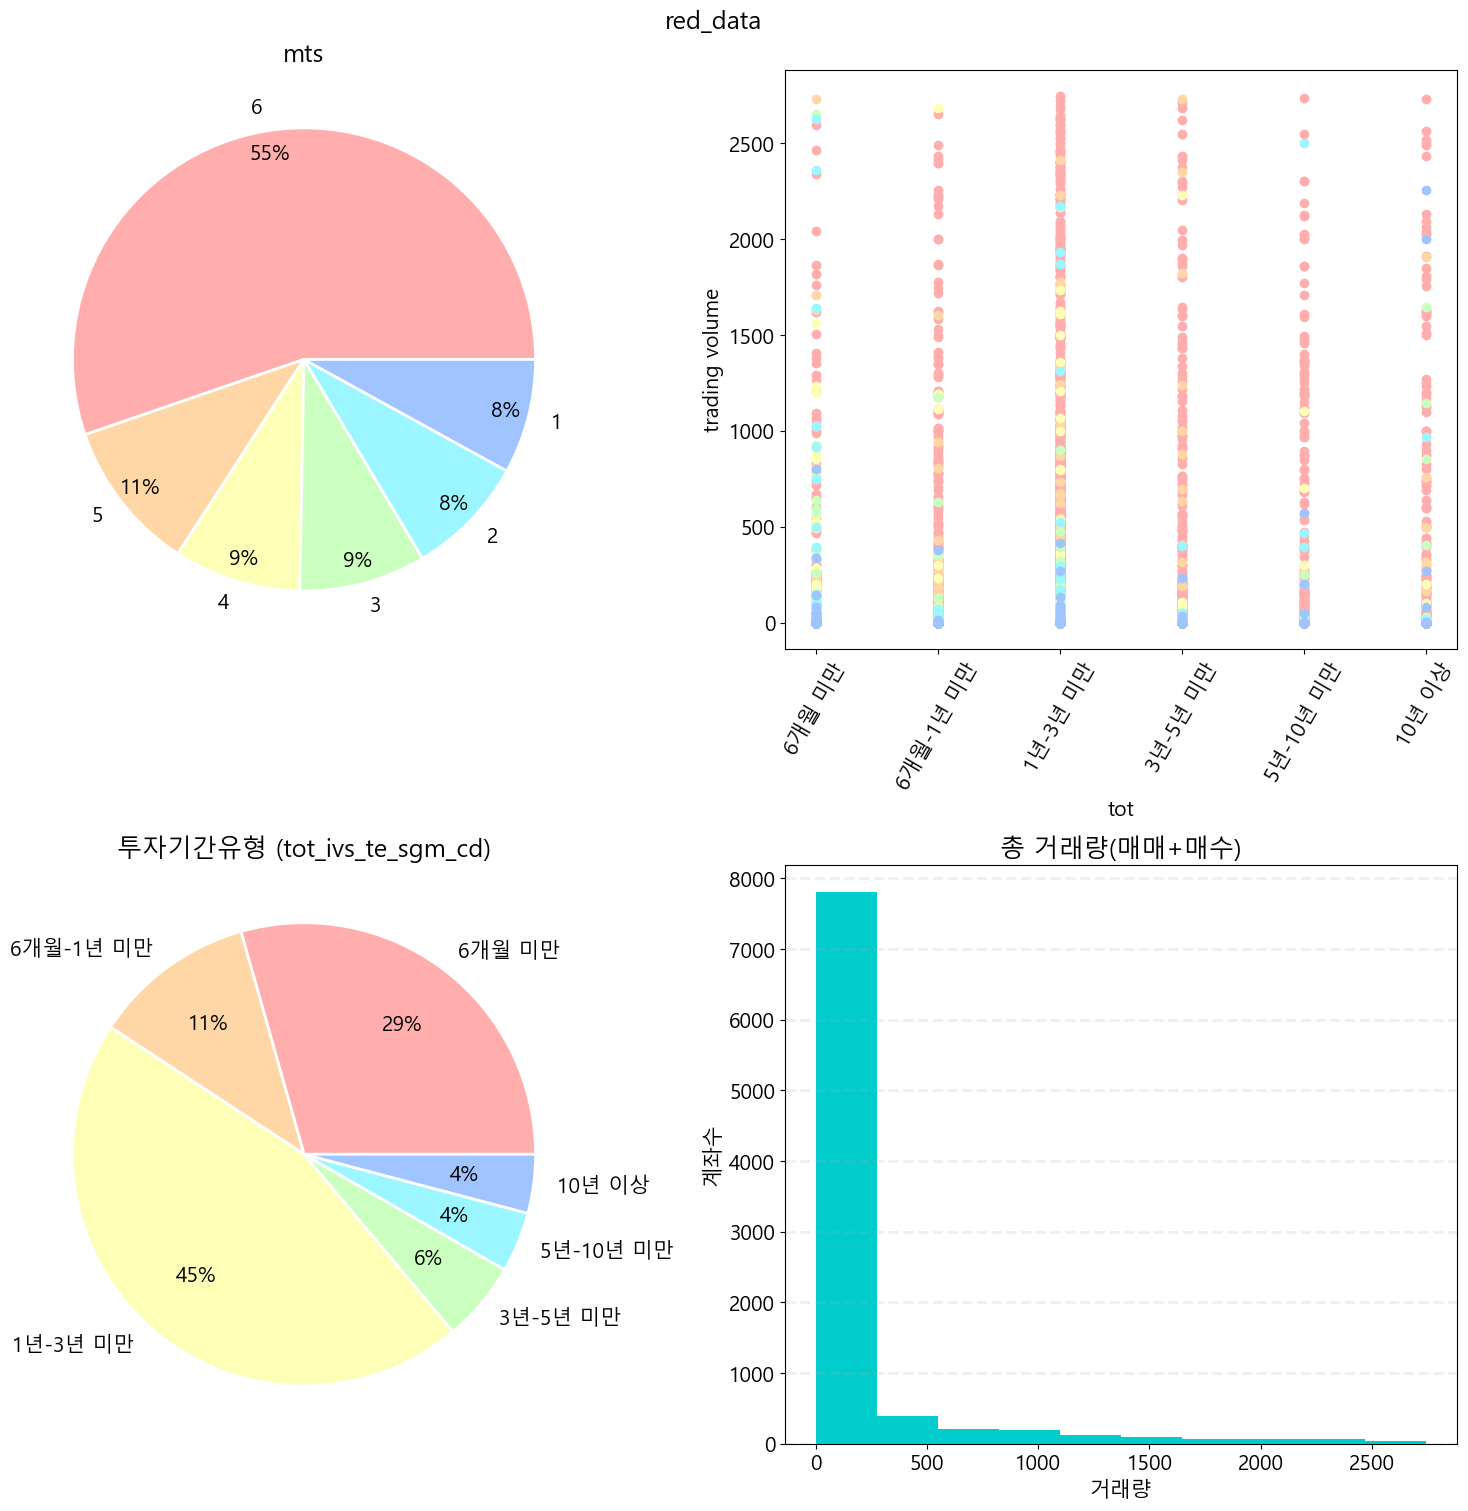

In [251]:
df_red=pd.DataFrame(X_red)

fig, axs=plt.subplots(2,2,figsize=(15,15), constrained_layout=True)
fig.suptitle('red_data')

#첫 번째 그래프
colors=['#ffadad', '#ffd6a5', '#fdffb6', '#caffbf', '#9bf6ff', '#a0c4ff']
wedgeprops={'edgecolor':'w', 'linewidth':2}
df_red_mts=df_red[1].value_counts()

axs[0, 0].pie(df_red_mts, labels=df_red_mts.index, autopct='%.0f%%', colors=colors, pctdistance=0.9, wedgeprops=wedgeprops)
axs[0, 0].set_title('mts')

#두 번째 그래프
k=0

for idx in df_red_mts.index:
    axs[0, 1].scatter(df_red.loc[df_red[1]==idx][2], df_red.loc[df_red[1]==idx][3], color=colors[k])
    axs[0, 1].set_xlabel('tot')
    axs[0, 1].set_ylabel('trading volume')
    k+=1
    
labels=['','6개월 미만','6개월-1년 미만', '1년-3년 미만', '3년-5년 미만', '5년-10년 미만', '10년 이상']    
axs[0, 1].set_xticklabels(labels,rotation=60)

#세 번째 그래프
df_red_tot=df_red[2].value_counts()
df_red_tot.sort_index(inplace = True)
labels=['6개월 미만','6개월-1년 미만', '1년-3년 미만', '3년-5년 미만', '5년-10년 미만', '10년 이상']

axs[1, 0].pie(df_red_tot, labels=labels, autopct='%.0f%%', colors=colors, pctdistance=0.7, wedgeprops=wedgeprops)
axs[1, 0].set_title('투자기간유형 (tot_ivs_te_sgm_cd)')

#네 번째 그래프
axs[1, 1].set_title('총 거래량(매매+매수)')
axs[1, 1].hist(df_red[3], color='#00CCCC')
axs[1, 1].set_xlabel('거래량')
axs[1, 1].set_ylabel('계좌수')
axs[1, 1].grid(axis='y',alpha=0.2,linestyle='--',linewidth=2)
axs[1, 1].grid(axis='x',alpha=0)

plt.show()

### 투자특성 분류
> 향후 curation에서 각자 투자특성에 맞는 포트폴리오를 추천하기 위해서 전체 데이터에서 clustering을 실행하였습니다.


- 데이터 추출

In [252]:
cus_ifo_1 = pd.read_csv("./cus_ifo.csv", header=0, usecols=['act_no', 'cus_aet_stn_cd', 'lsg_sgm_cd', 'mrz_pdt_tp_sgm_cd','bse_ym'])
cus_ifo_1=cus_ifo_1.loc[cus_ifo_1['bse_ym']==202206]

df = cus_ifo_1
del_list = []
for i in tqdm(df.columns):
    del_list += list(df[df[i].isin([99, "_"])].index)

new_df = df.drop(del_list).copy()
new_df.reset_index(drop=True,inplace=True)
cus_ifo_1 = new_df

data = cus_ifo_1.to_numpy()[:,2:]
print(data)

100%|██████████| 5/5 [00:00<00:00, 454.42it/s]

[[1 2 3]
 [1 2 5]
 [1 2 5]
 ...
 [1 2 4]
 [1 2 8]
 [1 3 4]]


- 데이터 시각화

In [253]:
def custom_autopct(pct):
    # return ('%.1f%%' % pct) if pct >=10 else ''
#     return '{:.1f}%'.format(pct) if pct>=10 else ''
    return '{:.0f}%'.format(pct) if pct>=0.2 else ''


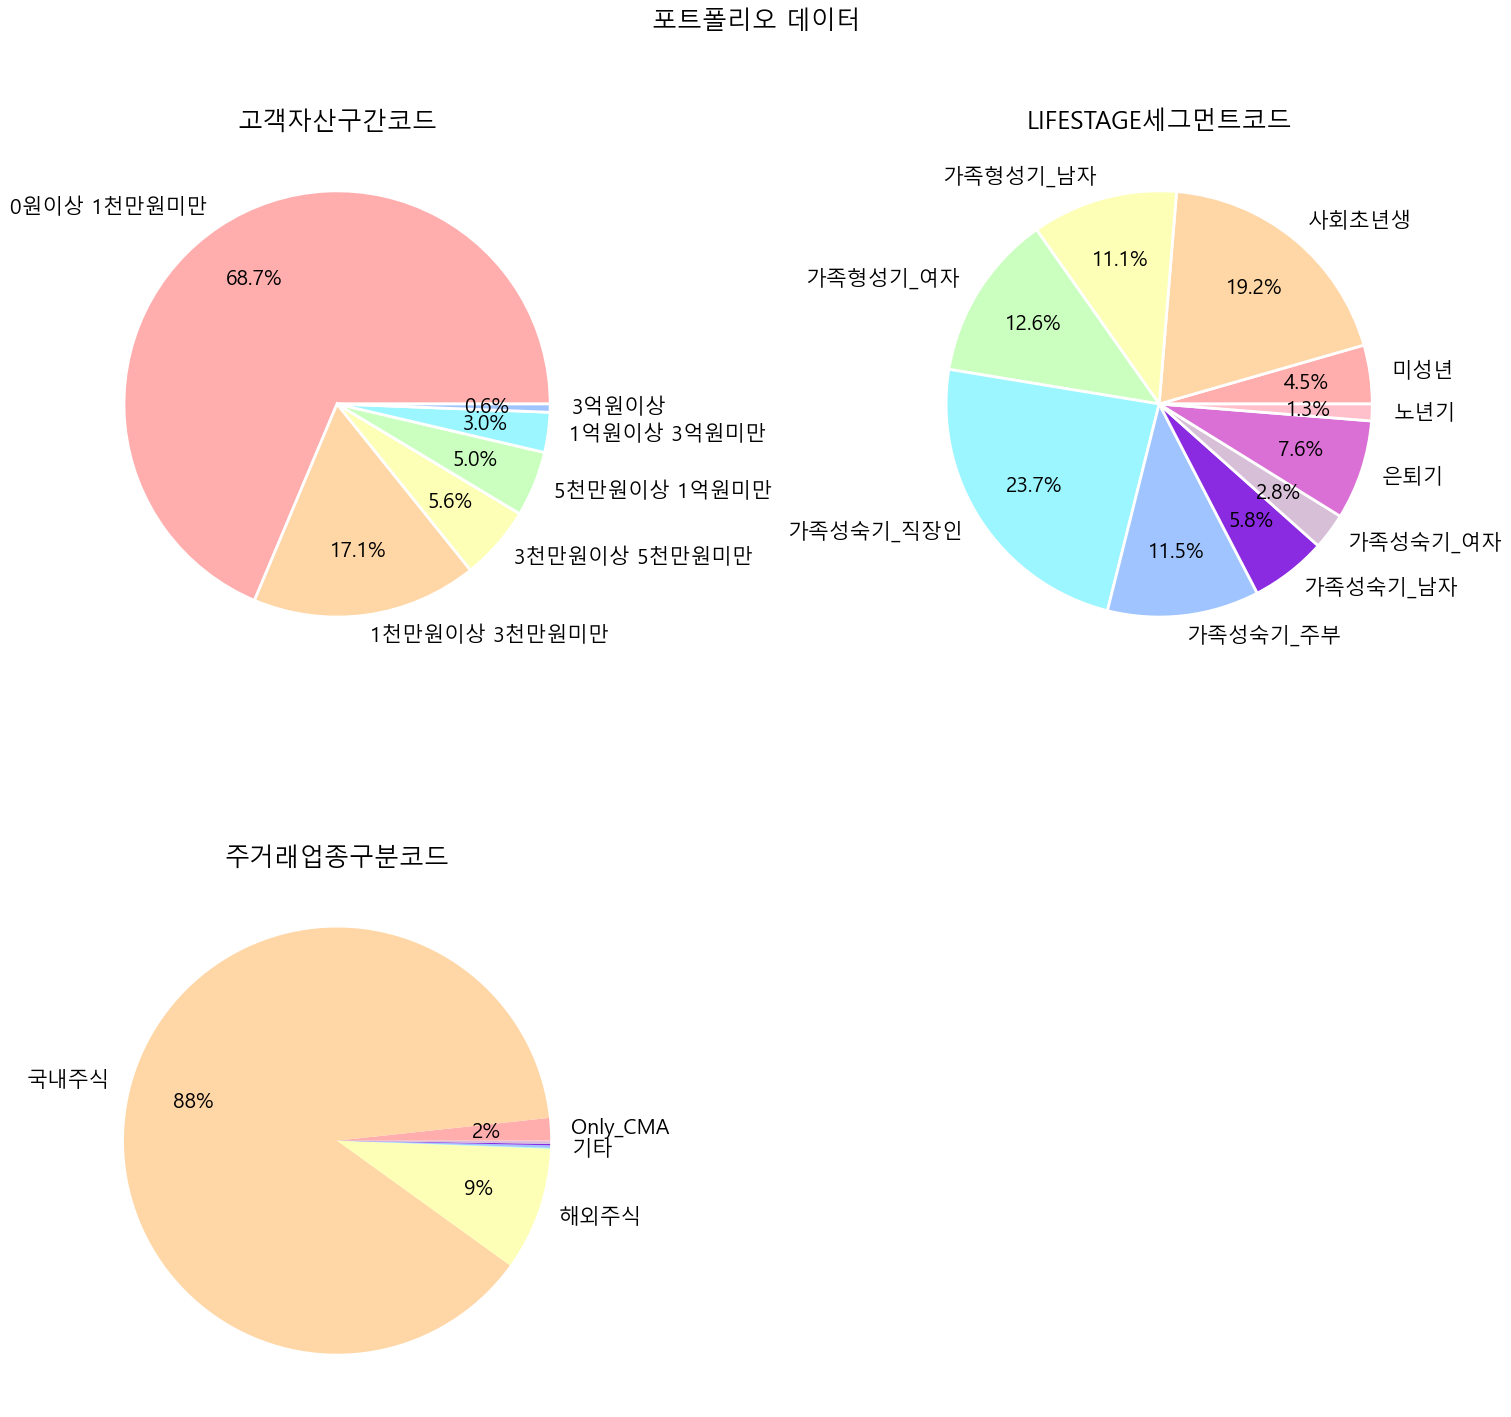

In [254]:
fig, axs=plt.subplots(2,2,figsize=(15,15), constrained_layout=True)
fig.suptitle('포트폴리오 데이터')
 
#첫 번째 그래프
colors=['#ffadad', '#ffd6a5', '#fdffb6', '#caffbf', '#9bf6ff', '#a0c4ff', '#8a2be2', '#D8BFD8', '#DA70D6', '#FFC0CB', '#D2691E']
wedgeprops={'edgecolor':'w', 'linewidth':2}

cus_aet=cus_ifo_1['cus_aet_stn_cd'].value_counts()
cus_aet.sort_index(inplace=True)
labels=["0원이상 1천만원미만", "1천만원이상 3천만원미만", "3천만원이상 5천만원미만", "5천만원이상 1억원미만", "1억원이상 3억원미만", "3억원이상"]
axs[0, 0].pie(cus_aet, labels=labels, autopct='%.1f%%', pctdistance=0.7, wedgeprops=wedgeprops, colors=colors)    
axs[0, 0].set_title('고객자산구간코드')

#두 번째 그래프
cus_isg=cus_ifo_1['lsg_sgm_cd'].value_counts()
cus_isg.sort_index(inplace=True)
labels = ["미성년", "사회초년생", "가족형성기_남자", "가족형성기_여자", \
    "가족성숙기_직장인", "가족성숙기_주부", "가족성숙기_남자", "가족성숙기_여자", "은퇴기", "노년기"]
axs[0, 1].pie(cus_isg, labels=labels, autopct='%.1f%%', pctdistance=0.7, wedgeprops=wedgeprops, colors=colors)    
axs[0, 1].set_title('LIFESTAGE세그먼트코드')

#세 번째 그래프
cus_mrz=cus_ifo_1['mrz_pdt_tp_sgm_cd'].value_counts()
cus_mrz.sort_index(inplace=True)
labels = ['Only_CMA', '국내주식', '해외주식', '기타']
for _ in range(len(cus_mrz.index)-4):
    labels.append('')
axs[1, 0].pie(cus_mrz, labels=labels, autopct=custom_autopct, pctdistance=0.7, colors=colors)
axs[1, 0].set_title('주거래업종구분코드')

fig.delaxes(axs[1][1])

plt.show()

- StandardScale

In [255]:
sc = StandardScaler()
data = sc.fit_transform(data)
data

array([[-0.54726787, -0.18255056, -0.70814396],
       [-0.54726787, -0.18255056,  0.19013685],
       [-0.54726787, -0.18255056,  0.19013685],
       ...,
       [-0.54726787, -0.18255056, -0.25900355],
       [-0.54726787, -0.18255056,  1.53755807],
       [-0.54726787,  1.34790063, -0.25900355]])

- Elbow Method

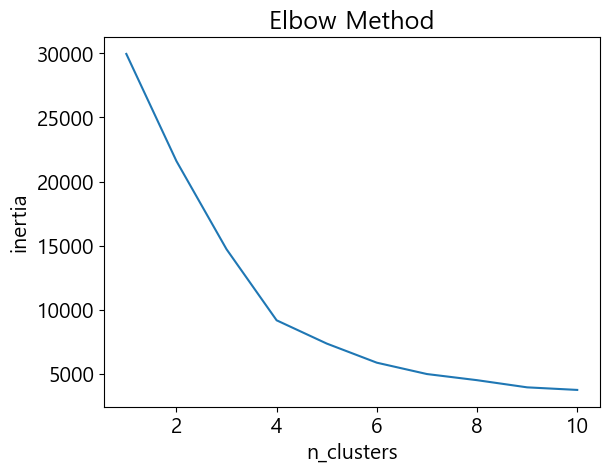

In [256]:
inertia_list = []
for i in range(1, 11):
    kmeans = KMeans(n_clusters=i, init='k-means++', random_state=0)
    kmeans.fit(data)
    inertia_list.append(kmeans.inertia_) # 각 지점으로부터 클러스터의 중심(centroid) 까지의 거리의 제곱의 합
    
plt.plot(range(1, 11), inertia_list)
plt.title('Elbow Method')
plt.xlabel('n_clusters')
plt.ylabel('inertia')
plt.show()

- Cluster 갯수

In [257]:
K = 4

- kMeans

In [258]:
kmeans = KMeans(n_clusters=4, random_state=0)
y_kmeans = kmeans.fit_predict(data)
cus_ifo_1['cluster'] = y_kmeans
cus_ifo_1

,act_no,bse_ym,cus_aet_stn_cd,mrz_pdt_tp_sgm_cd,lsg_sgm_cd,cluster
0,3610f0105b67e30709e55c546c75c45b8c9d589e90fb9f...,202206,1,2,3,0
1,afa2e6df88371acd0768c15a14aebf9e81ed131af729e3...,202206,1,2,5,1
2,726a3295019efd88142038b123013623e26a217d2b08df...,202206,1,2,5,1
3,4f2a78f9a162f9c82350f40627ce1062afaefeb4ff34e7...,202206,5,2,7,2
4,8010d50edbbcd1974e12cb20fbca3a3abea0088df3070e...,202206,1,2,4,0
...,...,...,...,...,...,...
9980,331ebc85b76813b4f37ace30577786f061df9b5a559644...,202206,1,2,5,1
9981,7cb8cdf0bdc909cafe3b4522c8afe86c3bae8acc81a31e...,202206,1,2,2,0
9982,e6d3e46bc3a679c2ac46811862787bbfda4fa59acc013d...,202206,1,2,4,0
9983,3fb721c5a808e4e848adebcf80cb1c9badff6382033b45...,202206,1,2,8,1


- Clustering 결과 시각화

[[1.17023675 2.12063134 2.63968433]
 [1.24885238 2.03599903 6.23822179]
 [3.93639053 2.06065089 5.84911243]
 [2.38983051 9.20338983 4.45762712]]


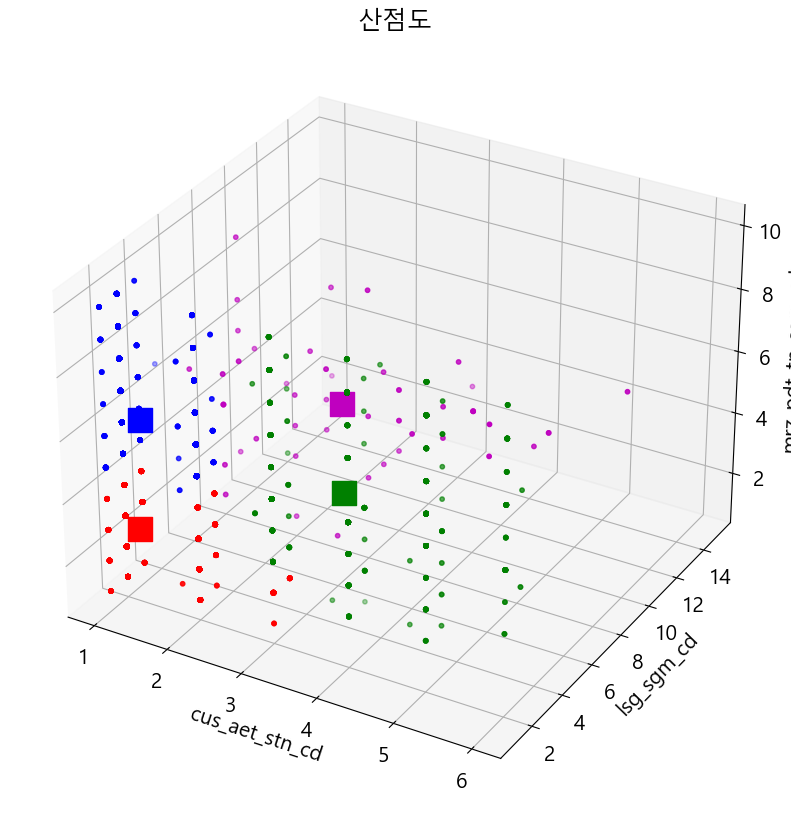

In [259]:
X_org = sc.inverse_transform(data)

centers_org = sc.inverse_transform(kmeans.cluster_centers_)
print(centers_org)

fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111, projection='3d')

color=['r','b', 'g', 'm']

for cluster in range(K):
    ax.scatter(X_org[y_kmeans == cluster, 0], X_org[y_kmeans == cluster, 1], X_org[y_kmeans == cluster, 2], s=10,color=color[cluster]) # 각 데이터
    ax.scatter(centers_org[cluster, 0], centers_org[cluster, 1],centers_org[cluster, 2] ,s=300, color=color[cluster], marker='s') # 중심점 네모

plt.title('산점도')
ax.set_xlabel('cus_aet_stn_cd')
ax.set_ylabel('lsg_sgm_cd')
ax.set_zlabel('mrz_pdt_tp_sgm_cd')
plt.show()

- 포트폴리오를 제공할 투자자
> 포트폴리오를 제공할 투자자들을 df_red를 이용해 추출함

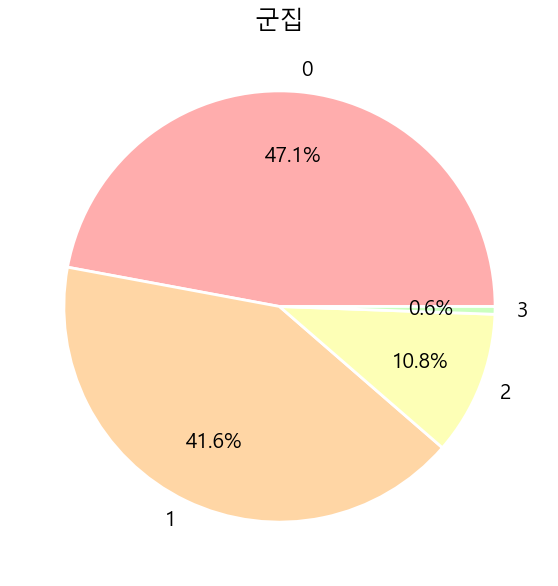

In [260]:
filt_red=cus_ifo_1['act_no'].isin(df_red.iloc[:,0]) 
cus_ifo_1 = cus_ifo_1[filt_red]
cus_red_cluster=cus_ifo_1['cluster'].value_counts()
plt.figure(figsize=(7,7))
plt.pie(cus_red_cluster, labels=cus_red_cluster.index, autopct='%.1f%%', pctdistance=0.7, wedgeprops=wedgeprops, colors=colors)
plt.title('군집')
plt.show()

## 고객유형 분석

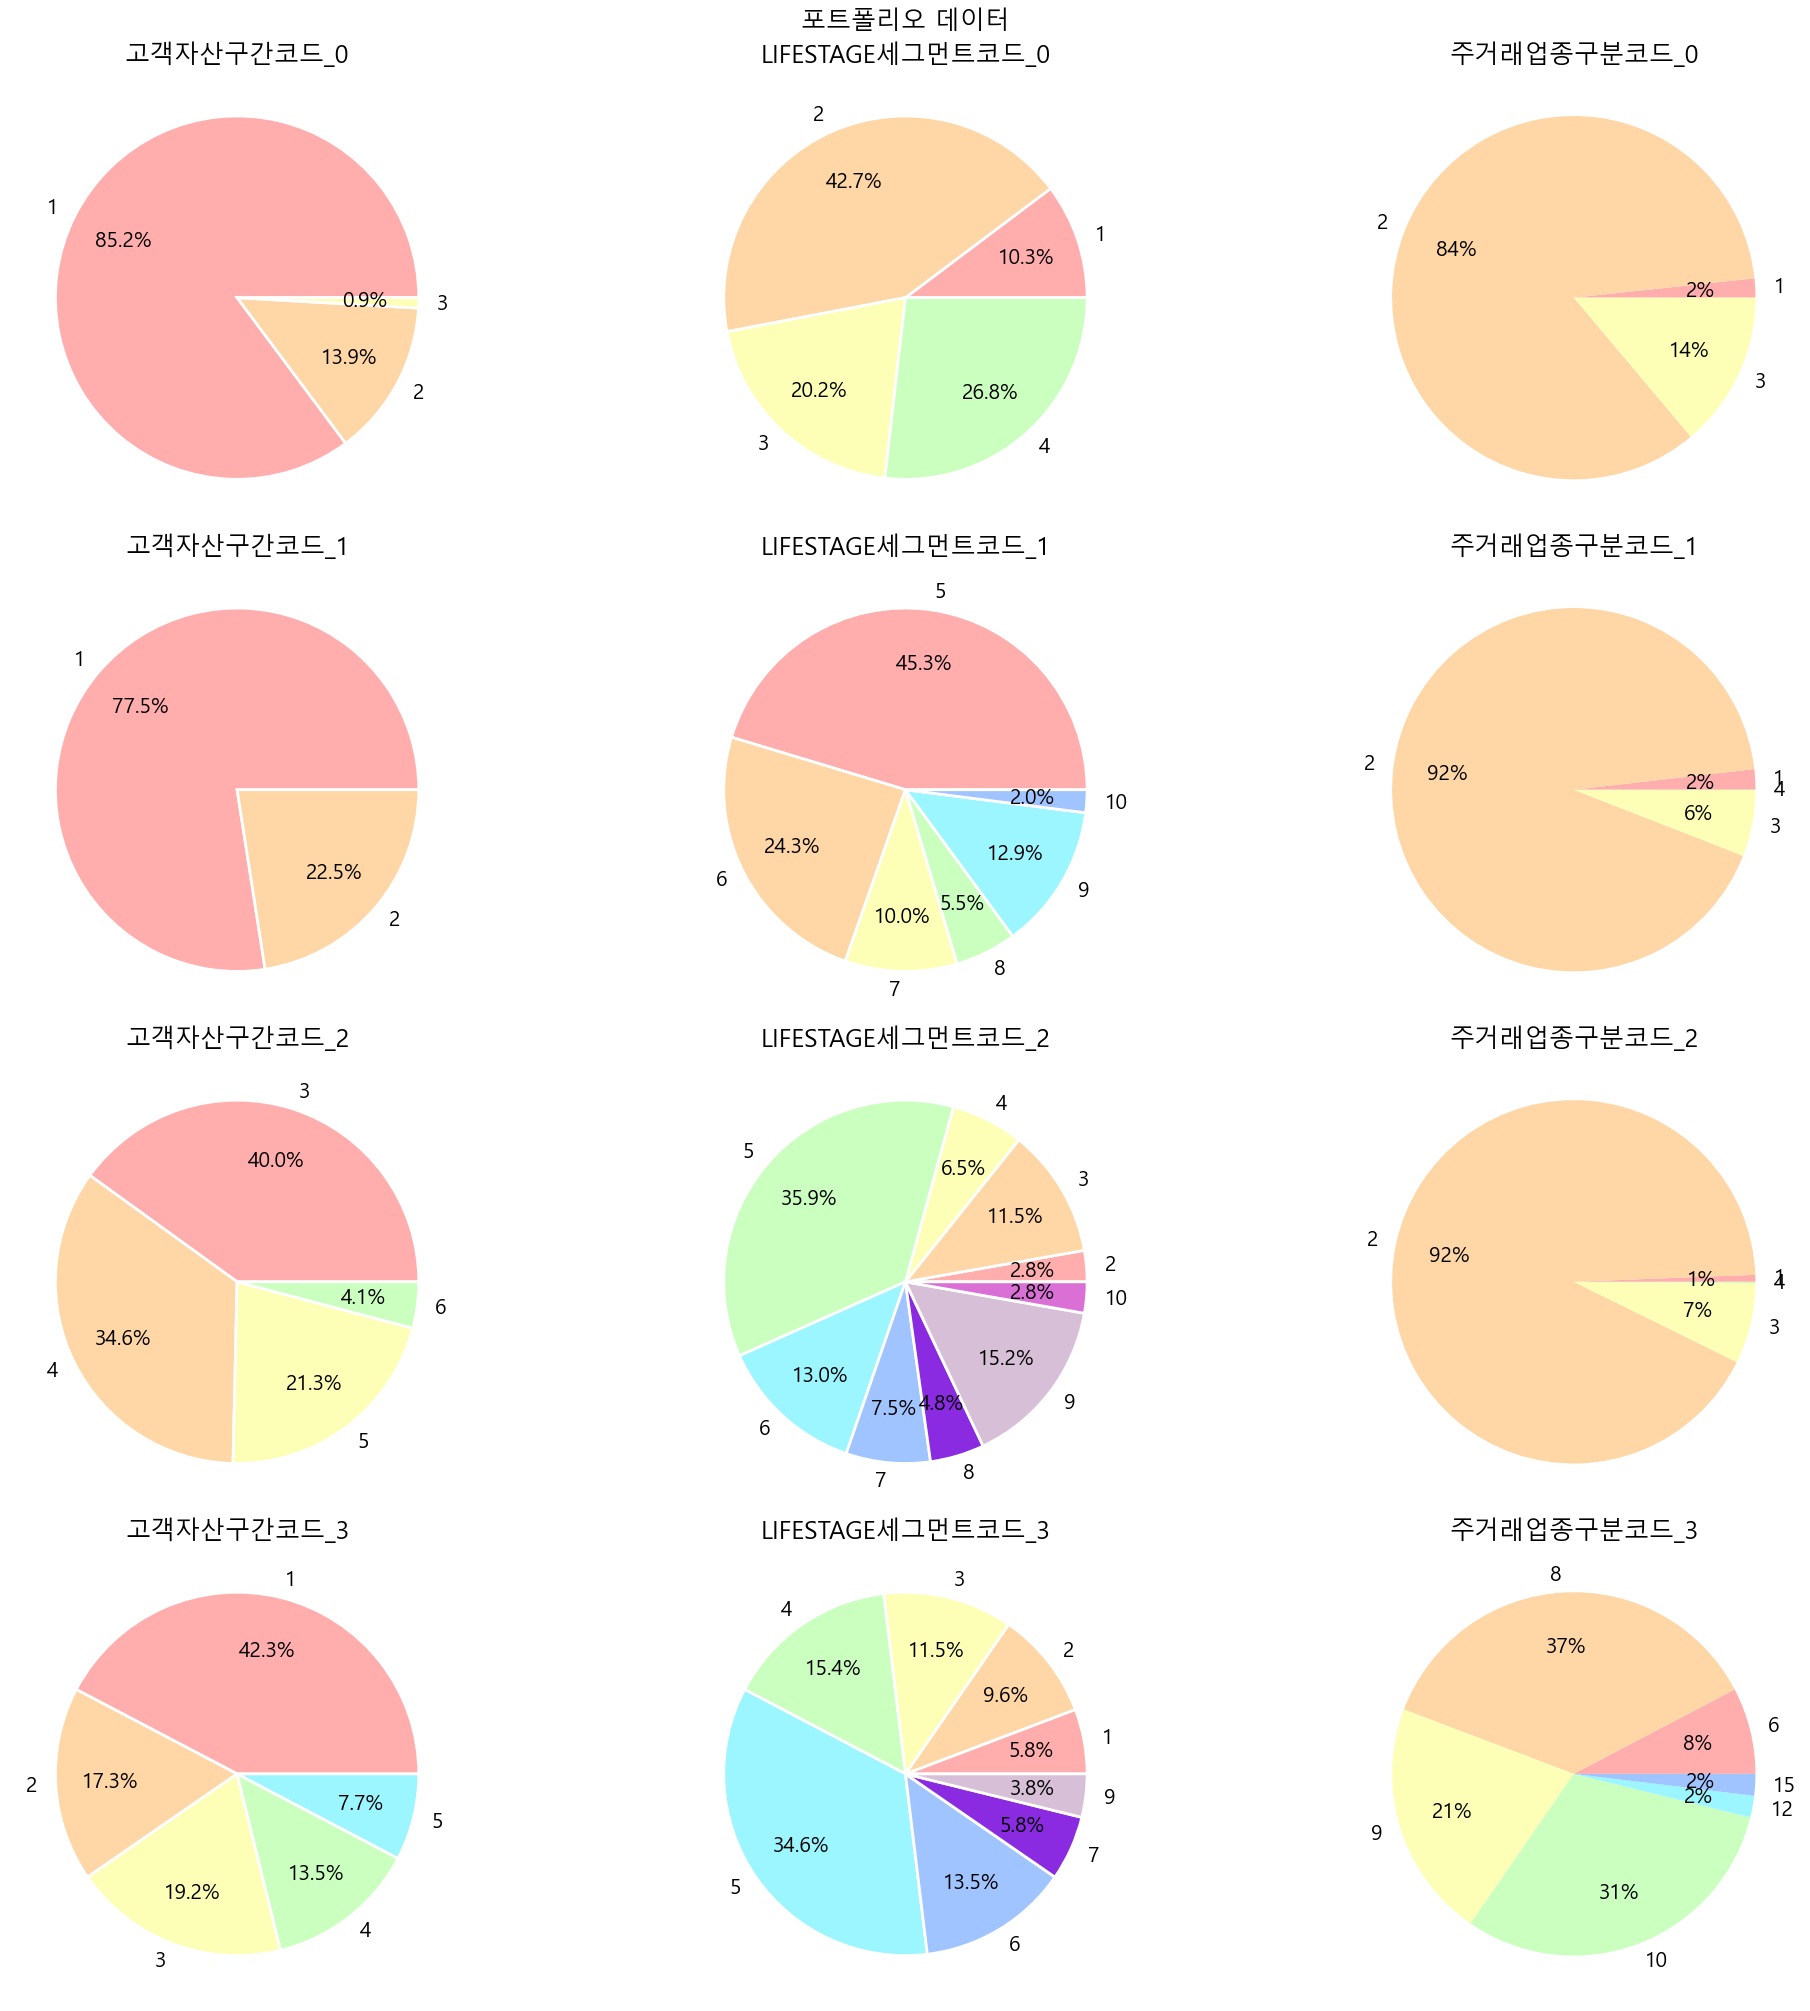

In [261]:
fig, axs=plt.subplots(4,3,figsize=(20,20), constrained_layout=True)
fig.suptitle('포트폴리오 데이터')

# cus_aet_stn_cd
# lsg_sgm_cd
# mrz_pdt_tp_sgm_cd

cl_0 = cus_ifo_1.loc[cus_ifo_1['cluster'] == 0]
cl_1 = cus_ifo_1.loc[cus_ifo_1['cluster'] == 1]
cl_2 = cus_ifo_1.loc[cus_ifo_1['cluster'] == 2]
cl_3 = cus_ifo_1.loc[cus_ifo_1['cluster'] == 3]
 

colors=['#ffadad', '#ffd6a5', '#fdffb6', '#caffbf', '#9bf6ff', '#a0c4ff', '#8a2be2', '#D8BFD8', '#DA70D6', '#FFC0CB', '#D2691E']
wedgeprops={'edgecolor':'w', 'linewidth':2}

#첫 번째 그래프
cl_00=cl_0['cus_aet_stn_cd'].value_counts()
cl_00.sort_index(inplace=True)
axs[0, 0].pie(cl_00, labels=cl_00.index, autopct='%.1f%%', pctdistance=0.7, wedgeprops=wedgeprops, colors=colors)    
axs[0, 0].set_title('고객자산구간코드_0')

cl_01=cl_0['lsg_sgm_cd'].value_counts()
cl_01.sort_index(inplace=True)
axs[0, 1].pie(cl_01, labels=cl_01.index, autopct='%.1f%%', pctdistance=0.7, wedgeprops=wedgeprops, colors=colors)    
axs[0, 1].set_title('LIFESTAGE세그먼트코드_0')

#세 번째 그래프
cl_02=cl_0['mrz_pdt_tp_sgm_cd'].value_counts()
cl_02.sort_index(inplace=True)
axs[0, 2].pie(cl_02, labels=cl_02.index, autopct=custom_autopct, pctdistance=0.7, colors=colors)
axs[0, 2].set_title('주거래업종구분코드_0')



#첫 번째 그래프
cl_10=cl_1['cus_aet_stn_cd'].value_counts()
cl_10.sort_index(inplace=True)
axs[1, 0].pie(cl_10, labels=cl_10.index, autopct='%.1f%%', pctdistance=0.7, wedgeprops=wedgeprops, colors=colors)    
axs[1, 0].set_title('고객자산구간코드_1')

cl_11=cl_1['lsg_sgm_cd'].value_counts()
cl_11.sort_index(inplace=True)
axs[1, 1].pie(cl_11, labels=cl_11.index, autopct='%.1f%%', pctdistance=0.7, wedgeprops=wedgeprops, colors=colors)    
axs[1, 1].set_title('LIFESTAGE세그먼트코드_1')

#세 번째 그래프
cl_12=cl_1['mrz_pdt_tp_sgm_cd'].value_counts()
cl_12.sort_index(inplace=True)
axs[1, 2].pie(cl_12, labels=cl_12.index, autopct=custom_autopct, pctdistance=0.7, colors=colors)
axs[1, 2].set_title('주거래업종구분코드_1')



#첫 번째 그래프
cl_20=cl_2['cus_aet_stn_cd'].value_counts()
cl_20.sort_index(inplace=True)
axs[2, 0].pie(cl_20, labels=cl_20.index, autopct='%.1f%%', pctdistance=0.7, wedgeprops=wedgeprops, colors=colors)    
axs[2, 0].set_title('고객자산구간코드_2')

cl_21=cl_2['lsg_sgm_cd'].value_counts()
cl_21.sort_index(inplace=True)
axs[2, 1].pie(cl_21, labels=cl_21.index, autopct='%.1f%%', pctdistance=0.7, wedgeprops=wedgeprops, colors=colors)    
axs[2, 1].set_title('LIFESTAGE세그먼트코드_2')

#세 번째 그래프
cl_22=cl_2['mrz_pdt_tp_sgm_cd'].value_counts()
cl_22.sort_index(inplace=True)
axs[2, 2].pie(cl_22, labels=cl_22.index, autopct=custom_autopct, pctdistance=0.7, colors=colors)
axs[2, 2].set_title('주거래업종구분코드_2')



#첫 번째 그래프
cl_30=cl_3['cus_aet_stn_cd'].value_counts()
cl_30.sort_index(inplace=True)
axs[3, 0].pie(cl_30, labels=cl_30.index, autopct='%.1f%%', pctdistance=0.7, wedgeprops=wedgeprops, colors=colors)    
axs[3, 0].set_title('고객자산구간코드_3')

cl_31=cl_3['lsg_sgm_cd'].value_counts()
cl_31.sort_index(inplace=True)
axs[3, 1].pie(cl_31, labels=cl_31.index, autopct='%.1f%%', pctdistance=0.7, wedgeprops=wedgeprops, colors=colors)    
axs[3, 1].set_title('LIFESTAGE세그먼트코드_3')

#세 번째 그래프
cl_32=cl_3['mrz_pdt_tp_sgm_cd'].value_counts()
cl_32.sort_index(inplace=True)
axs[3, 2].pie(cl_32, labels=cl_32.index, autopct=custom_autopct, pctdistance=0.7, colors=colors)
axs[3, 2].set_title('주거래업종구분코드_3')

plt.show()

- 0번 투자자
> 자산이 많지 않은 청년층 국내주식 위주 투자자
- 1번 투자자
> 투자에 적극적이지 않은 중년층 국내주식 위주 투자자
- 2번 투자자
> 투자에 적극적인 다양한 연령대의 국내주식 위주 투자자
- 3번 투자자
> 주식 이 외의 자산에 투자하는 투자자

## 데이터 저장

In [262]:
df_red.to_csv('./포트폴리오_제공_고객군', encoding='UTF-8')